In [1]:
import os
import numpy as np
from PIL import Image
import cv2
from glob import glob 
from tqdm import tqdm
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

2.2.2+cu121 True
1.2.2


## Finetune a semantic segmentation model on a new dataset

To finetune on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure. . 

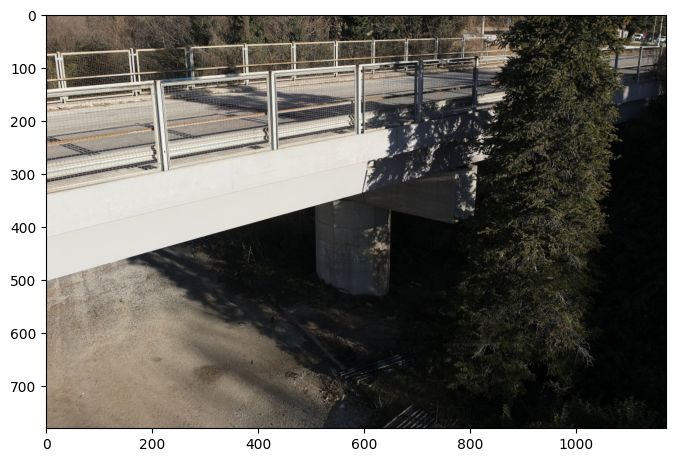

In [2]:
import mmcv
import mmengine
import matplotlib.pyplot as plt


img = mmcv.imread('data/Step_B_C60/RawImages_7x_downscaled/DJI_20240129094554_0369.JPG')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [3]:
# define dataset root and directory for images and annotations
data_root = '/home/teshbek/Work/Bridges_Project/Bridge-Seg/data/Step_B_C60'
img_dir = 'RawImages_7x_downscaled'
ann_dir = 'RawImages_masks_7x_downscaled'
# define class and palette for better visualization
classes = ('bridge',)
palette = [[1, 1, 1],]

In [4]:
prepare_images = True
if prepare_images:
    new_folder_path = os.path.join(data_root, ann_dir) + '_1channel'
    if not os.path.exists(new_folder_path):
        os.makedirs(new_folder_path)

    for filepath in tqdm(glob(os.path.join(data_root, ann_dir, f'*.png')), desc ="Images resize and save", unit = " images"):
        mask = cv2.imread(filepath)
        mask = mask.astype(np.uint8)
        if len(mask.shape)>2:
            mask = mask[:, :, 0]
        mask[mask == 255] = 1
        mask[~mask == 1] = 0 
        filename = os.path.join(new_folder_path, os.path.basename(filepath))
        cv2.imwrite(filename, mask) 
    ann_dir = 'RawImages_masks_7x_downscaled_1channel'


Images resize and save: 100%|██████████| 149/149 [00:01<00:00, 126.88 images/s]


In [6]:
# split train/val set randomly
split_dir = 'splits'
mmengine.mkdir_or_exist(os.path.join(data_root, split_dir))
filename_list = [os.path.splitext(filename)[0] for filename in mmengine.scandir(
    os.path.join(data_root, ann_dir), suffix='.png')]
with open(os.path.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(os.path.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [7]:
# from mmseg.registry import DATASETS
# from mmseg.datasets import BaseSegDataset


# @DATASETS.register_module()
# class BrigeC60(BaseSegDataset):
#   METAINFO = dict(classes = classes, palette = palette)
#   def __init__(self, **kwargs):
#     super().__init__(img_suffix='.JPG', seg_map_suffix='.png', **kwargs)
    

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [25]:
from mmengine import Config
import warnings
warnings.filterwarnings('ignore')

cfg = Config.fromfile('../mmsegmentation/configs/deeplabv3plus/deeplabv3plus_r18b-d8_4xb2-80k_cityscapes-769x769.py')

cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (720, 720)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

# Modify dataset type and path
cfg.dataset_type = 'BrigeC60'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 4

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(1280, 720), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(1280, 720), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# Load the pretrained weights
cfg.load_from = '/home/teshbek/Work/Bridges_Project/deeplabv3plus_r18b-d8_769x769_80k_cityscapes_20201226_151312-2c868aff.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/bridge_binary'

cfg.train_cfg.max_iters = 200
cfg.train_cfg.val_interval = 50
cfg.default_hooks.logger.interval = 10
cfg.default_hooks.checkpoint.interval = 50

cfg.optim_wrapper.optimizer.lr = 0.002
# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

config_path ='configs/deeplab.py'
with open(config_path, 'w') as f:
    f.write(cfg.pretty_text)

Config:
crop_size = (
    720,
    720,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        769,
        769,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = '/home/teshbek/Work/Bridges_Project/Bridge-Seg/data/Step_B_C60'
dataset_type = 'BrigeC60'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=50, type='CheckpointHook'),
    logger=dict(interval=10, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
  

### Train and Evaluation

In [21]:
# from mmengine.runner import Runner
# runner = Runner.from_cfg(cfg)
# runner.train()

# !python mmsegmentation/tools/train.py /home/teshbek/Work/Bridges_Project/Bridge-Seg/configs/deeplab.py --amp 

Inference with trained model

In [26]:
from mmseg.apis import init_model, inference_model, show_result_pyplot
# Init the model from the config and the checkpoint
checkpoint_path = 'weights/deeplabv3plus_mmseg_C60.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: /home/teshbek/Work/Bridges_Project/work_dirs/bridge_binary/iter_200.pth


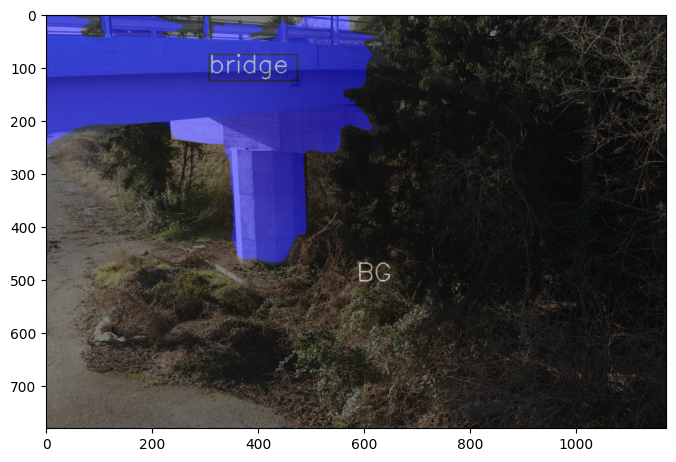

In [32]:
from natsort import natsorted
from random import sample 
import os 
resized_images_folder_path = os.path.join(data_root, img_dir)
image_paths = list(glob(os.path.join(resized_images_folder_path, '*.JPG')))
image_paths = natsorted(image_paths, key=lambda y: y.lower())[149:]
image_path = sample(image_paths, 1)[0]



img = mmcv.imread( image_path)
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
palette = [[0, 0, 0], [255, 1, 1]]
model.dataset_meta['palette'] = palette
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))
